# TP Performance prediction loyer

L'objectif est d'améliorer le modèle de prédiction de loyer, pour obtenir un modèle plus performant. Pour cela, il faut prendre en compte un nouveau données d'entrée l'arrondissement de l'appartement.


# 1. La mission:
Tester plusieurs manières d'améliorer la modélisation avec:

    - une séparation en training / testing set
    - 2 propositions d'amélioration du modèle qui obtiennent de meilleures performances que la "baseline" (la régression linéaire avec une seule feature)
    - Une sélection d'un modèle final à partir des performances


# 2. Préliminaire:

In [105]:
# Premièrement, on importes toutes les outils dont on aurait besoins dans tout le TP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# 2. Acquisition et néttoyage des données:

In [106]:
# Un premier aperçu de notre dataset
data_house = pd.read_csv('house_data.csv')
print('Notre dataset contient ',data_house.shape[0],' ligne et ', data_house.shape[1],' colonne.')
data_house.tail()

Notre dataset contient  827  ligne et  3  colonne.


,price,surface,arrondissement
822,850,35.00,10.0
823,700,10.00,10.0
824,1280,34.00,10.0
825,1545,65.00,10.0
826,1000,21.43,10.0


In [107]:
# Vérifier l'homogéneité des valeurs
print('Les appartements sont répartis sur ', data_house["arrondissement"].unique(), 'arrondissement.')

Les appartements sont répartis sur  [ 1. nan  2.  3.  4. 10.] arrondissement.


In [108]:
# Comme douté, le dataset contient des NaN qu'il faut enlever
data_house = data_house.dropna()
data_house.describe(include='all')

,price,surface,arrondissement
count,822.000000,822.000000,822.000000
mean,2010.306569,58.045925,4.142336
std,1895.091794,44.827522,3.202151
min,390.000000,10.000000,1.000000
25%,1052.500000,28.655000,2.000000
50%,1564.500000,46.100000,3.000000
75%,2348.000000,73.000000,4.000000
max,25000.000000,415.000000,10.000000


On voit que le loyer monte jusqu'à 25000 € , ce qui est énorme tandis que la moyenne est aux alentour de 2000.
Il y a une très forte dispersion du loyer 1895 qui est à peu près égale à la moyenne.
Après recherche sur internet, le loyer max à Paris est de 40,6 € par m2.
Donc on peut supposer que les loyers supérieurs à 40,6 x 415 m2 ~ 17.000€ sont abberants.

/home/maiky/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home/maiky/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/maiky/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


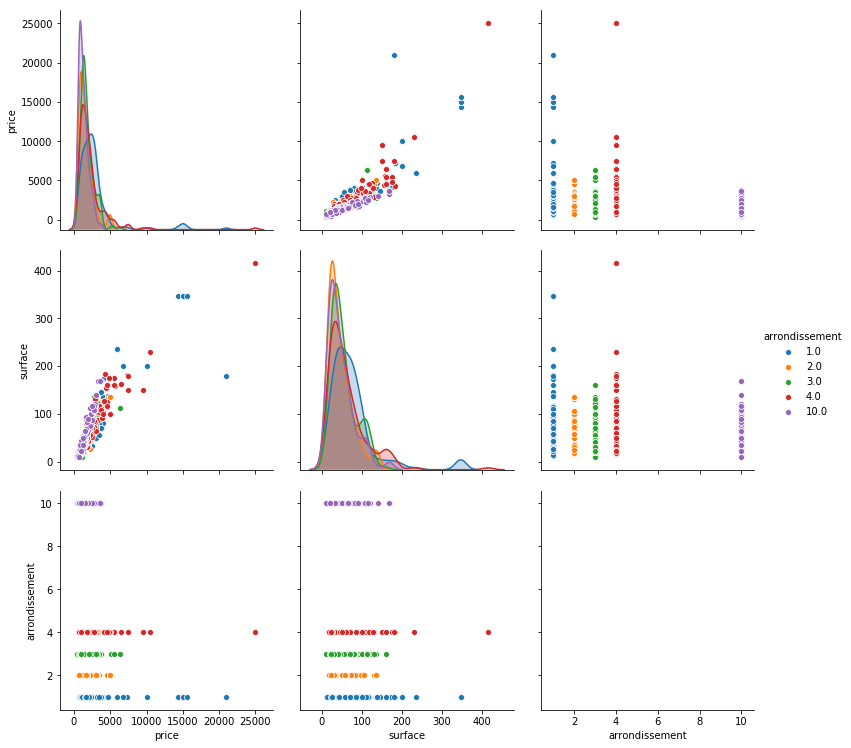

In [109]:
# Apreçu global
sns.pairplot(data_house, hue='arrondissement', size=3.5)

Trois loyers (en bleus) dépassent 14.000€ dans le 1er arrondissement.
Ces logements ont une superficie de 300m2, ce qui justifie le loyer.
Mais par contre, ces données ne vont fausser notre modèle puisqu'elles s'écartent de la normale.
Pour conserver la robustesse du modèle à ces données plutôt anormales, on va enlever les loyer supérieur à 10.000€ comme dans le cours.

In [110]:
data_house = data_house[data_house["price"] < 10000]

# 3. Visualisation de jeux de données par arrondissement:

Cette partie n'est pas nécessaire par rapport à ce qui est attendues dans le TP, elle sert juste à nous donner une aperçu de nos jeux de données.
Ici, on va observer l'évolution des loyer sur chaque arrondissement.

Text(0.5, 0, 'Prix')

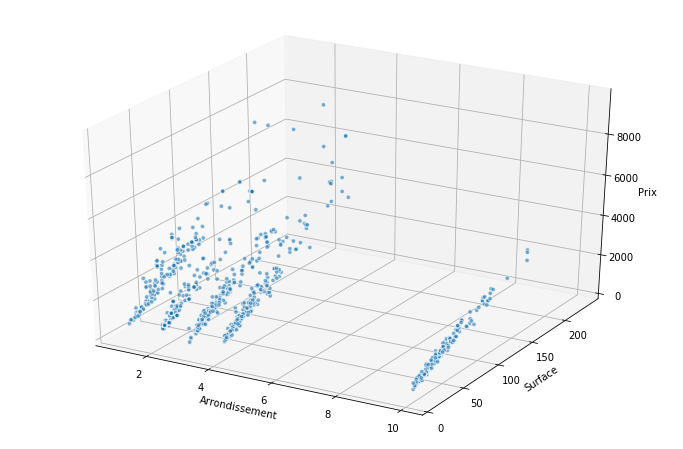

In [111]:
# Et si on affiche nos nuages de points dans l'espace 3 dimension
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_house['arrondissement'], data_house['surface'], data_house['price'], s=20, alpha=0.6, edgecolors='w')
ax.set_xlabel('Arrondissement')
ax.set_ylabel('Surface')
ax.set_zlabel('Prix')

Soyons franc, cette courbe ne va pas nous servir dans notre TP. Cette représentation est là juste pour faire jolie. ;)
Pour le fun !!!

Dans la suite, on va entrainer notre modèle par arrondissement en 2D.

In [112]:
arrondissements = data_house["arrondissement"].unique().astype(int)
data2 = []
# On sépare les correspondance prix-surface dans la liste data2
# où chaque éléments de la liste est associé à un "arrondissements"
for i in arrondissements:
    data2.append(data_house[data_house["arrondissement"]==i])
    data2[len(data2)-1].drop(columns=["arrondissement"])


In [113]:
# Séparons nos jeux de données en 80% pour le training et le reste pour le testing set
# Nous allons utiliser la fonction train_test_split présentée dans le cours
xtrain = []
xtest = []
ytrain = []
ytest = []
# On stockera dans cette liste tous nos coefficients par arrondissement.
theta2 = []

for index in range(5):
    xitrain, xitest, yitrain, yitest = train_test_split(data2[index]['surface'], data2[index]['price'], train_size=0.8)
    xtrain.append(xitrain)
    xtest.append(xitest)
    ytrain.append(yitrain)
    ytest.append(yitest)
    
    # Entrainement du modèle
    x = np.matrix([np.ones(xitrain.shape[0]), xitrain.as_matrix()]).T
    y = np.matrix(yitrain).T
    theta2.append(np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y))

/home/maiky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


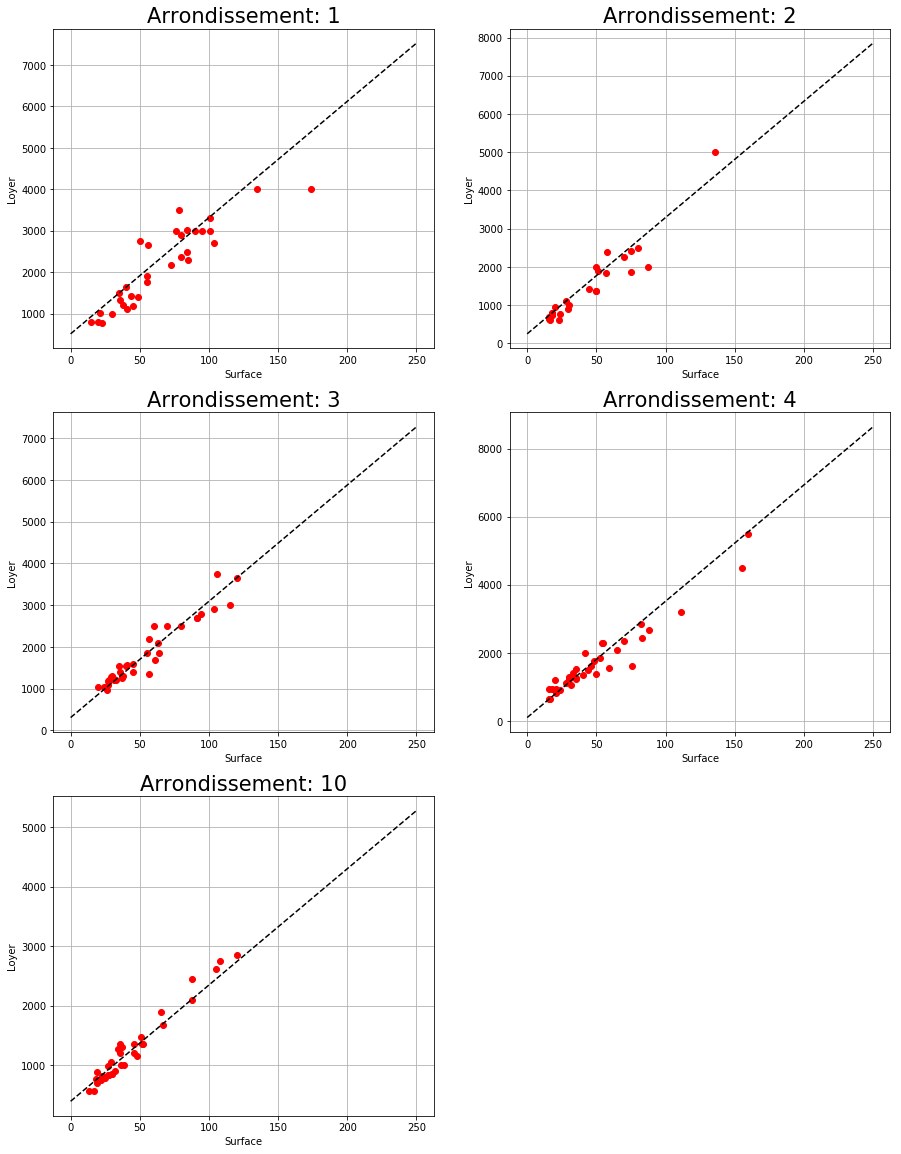

In [114]:
# Passons maintenant à la prédiction pour vérifier l'éfficacité de notre apprentissage
# Nous allons faire cela grâce à nos data test
fig = plt.figure(figsize=(15,20))
for index in range(5):
    fig.add_subplot(3,2, index+1)
    plt.plot(xtest[index], ytest[index],'ro')
    plt.plot([0,250], [theta2[index].item(0), theta2[index].item(0) + 250 * theta2[index].item(1)], linestyle='--', c='#000000')
    plt.title('Arrondissement: %i' %arrondissements[index], fontsize=21)
    plt.xlabel('Surface')
    plt.ylabel('Loyer')
    plt.grid(True)

On voit que notre modèle suit arrive à prédire les différentes points de notre data test.
Sauf dans l'arrondissement 1 et 3 où l'on voit des écart à partir de 50 et 100 m2.
Et si nous mettons toutes nos courbes sur une seule graphe.

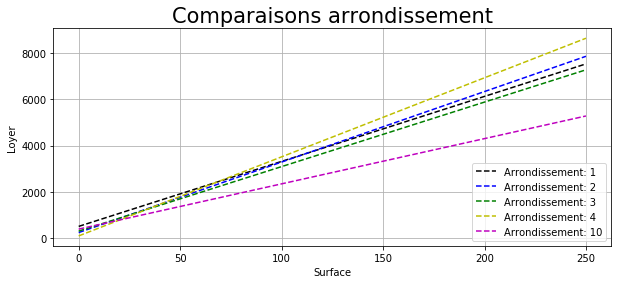

In [115]:
# Couleur des courbes pour les différencier
couleurs = ['k', 'b', 'g', 'y', 'm']
fig = plt.figure(figsize=(10,4))
for index in range(5):
    plt.plot([0,250], [theta2[index].item(0),
                       theta2[index].item(0) + 250 * theta2[index].item(1)],
             linestyle='--', color= couleurs[index],
             label='Arrondissement: %i' %arrondissements[index])
    plt.legend(loc='lower right');
    plt.title('Comparaisons arrondissement', fontsize=21)
    plt.xlabel('Surface')
    plt.ylabel('Loyer')
    plt.grid(True)

Cette courbe nous dit que les loyer sont presque identique en-dessous de 50m2. Et le 4eme arrondissement est le plus onéreux au de 50m2 tandis que le 10eme arrondissement est le moins cher.

# 4. Méthode regression linéaire multiple avec LinearRegression().fit(x,y):

Dans cette partie, "sklearn.LinearRegression()" va calculer les coeffficients pour nous.
Les problèmes à multiples variables sont représentées comme:

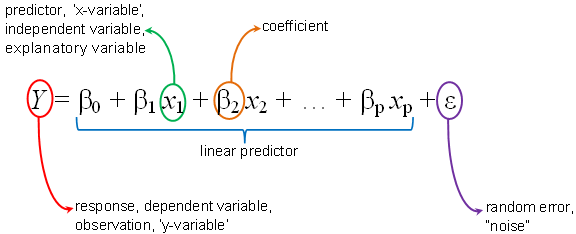

La procédure de modélisation est presque pareil que celles des cas bi-dimensionnels.
La différence se situe au niveau des l'évaluation de variable en entrée x.
Dans notre cas, on aura deux types d'entrées: surface et arrondissement.

In [116]:
x = data_house[['surface','arrondissement']].values
y = data_house['price'].values

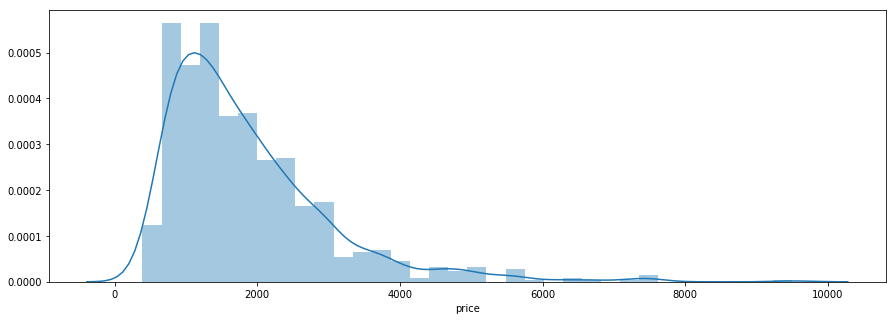

In [117]:
# Vérifions la moyenne des prix
plt.figure(figsize=(15,5))
plt.tight_layout()
sns.distplot(data_house['price'])

On voit que la majorité des loyer sont entre ~500 et 2500 euro.
On va maintenant séparer notre jeux de donnée avec 80% pour l'entrainement du model et le reste pour le test.

In [118]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)

In [119]:
# Passons maintenant à l'entrainement de notre modèle
regresseur = LinearRegression()
regresseur.fit(x_train, y_train)
print(regresseur.intercept_)

490.3518789069783


In [120]:
# Notre modèle de regression devait chercher le coefficient optimal pour chacun des variables d'entrées.
# Voici les coefficients trouvés:
coeff_dh = pd.DataFrame(regresseur.coef_, index = ['surface', 'arrondissement'], columns=['Coefficients'])
coeff_dh

,Coefficients
surface,28.550144
arrondissement,-49.832718


La valeur négative du coeff arrondissement traduit que plus on éloigne du coeur de Paris, le loyer sera reduit de 50 euro.

In [121]:
# Testons nos data_test
y_pred = regresseur.predict(x_test)
dh = pd.DataFrame({'Actuel': y_test, 'Prédicted': y_pred})
dh.head(10)

,Actuel,Prédicted
0,1650,1703.111151
1,1400,1332.841209
2,2290,2467.579415
3,2300,2146.780395
4,2941,3181.333026
5,2249,1439.774216
6,1900,1654.160369
7,4250,3802.688772
8,1375,1818.193665
9,550,391.726724


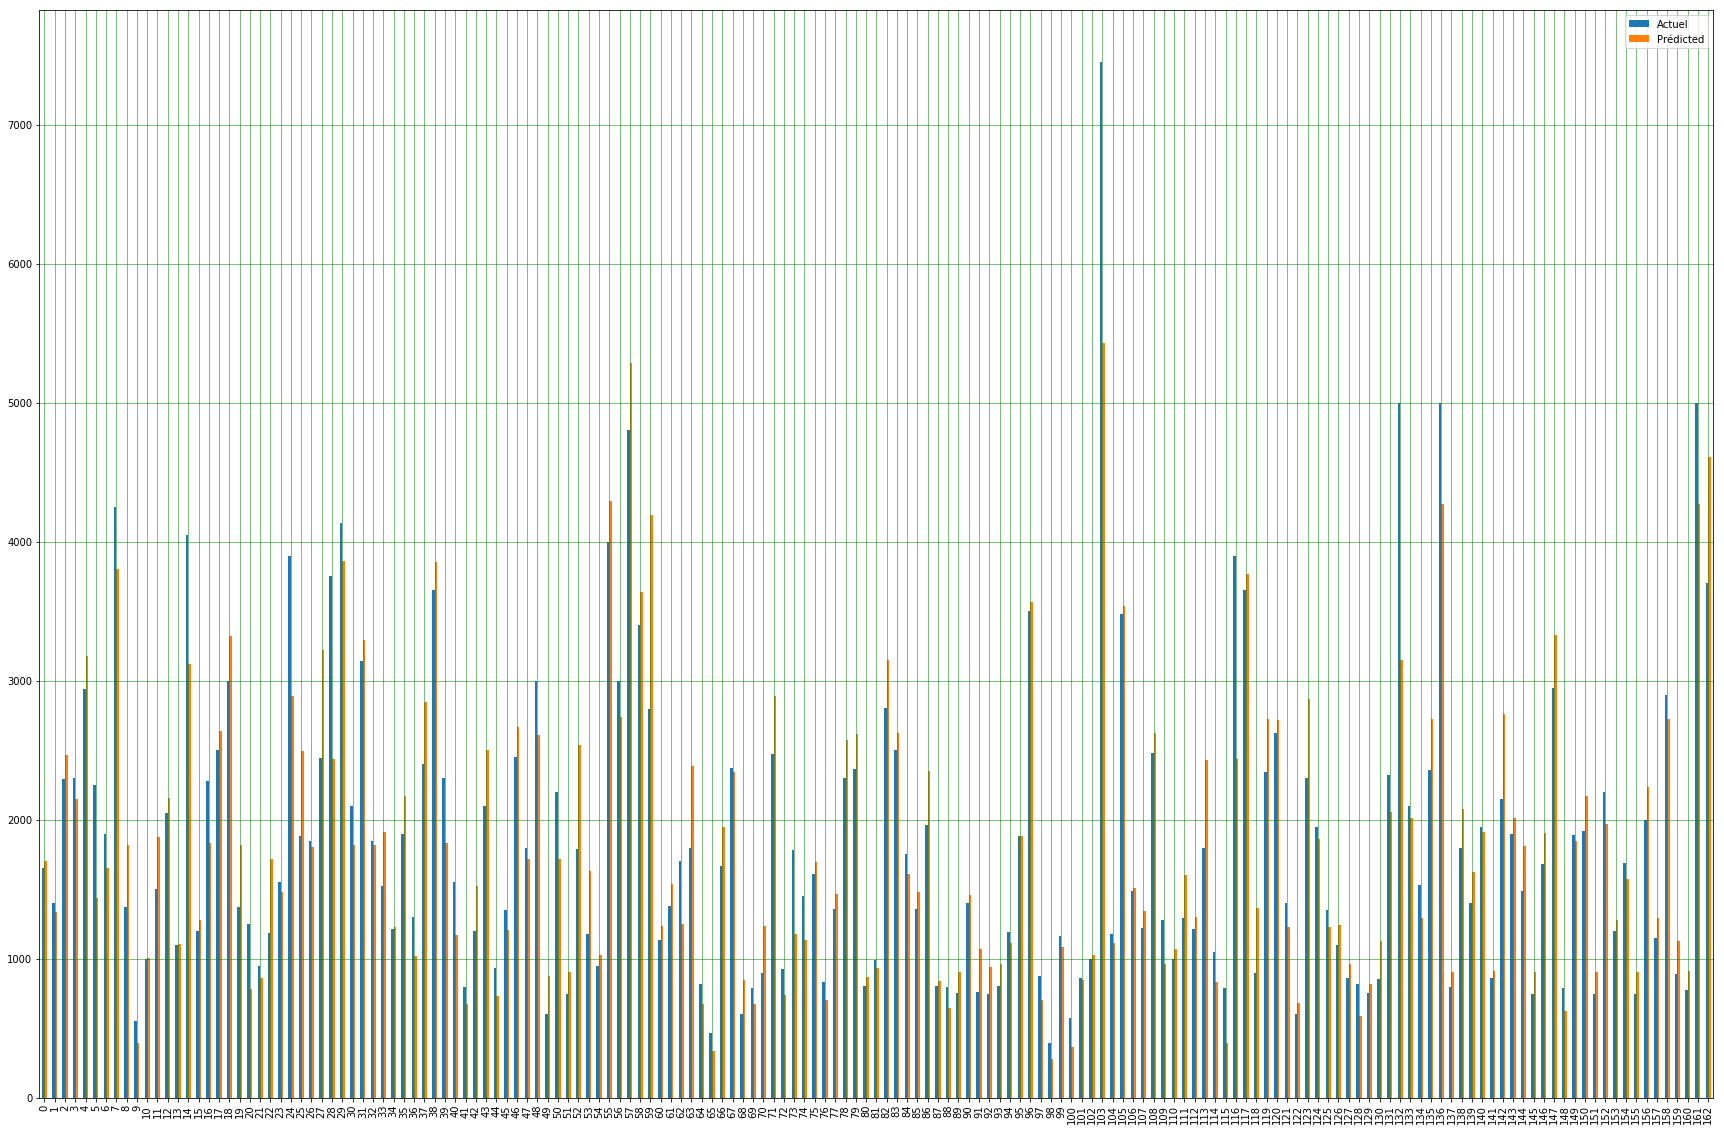

In [122]:
# Si on compare les deux valeurs sur à l'aide d'un histogramme
dh.plot(kind='bar', figsize=(30,20))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle='-', linewidth='0.5', color='black')
plt.show()

On voit que notre modèle retourne pas mal de bonne résultat sur la majorité des cas, sauf sur les cas avec des prix élevées.
La dernière étape pour évaluer la performance de notre algorithme est de regarder les erreurs.

In [123]:
print('Erreur absolue moyenne: ', metrics.mean_absolute_error(y_test, y_pred))
print('Erreur quadratique moyenne', metrics.mean_squared_error(y_test, y_pred))
print('Racine carrée de l erreur quadratique moyenne: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Erreur absolue moyenne:  289.2140180418792
Erreur quadratique moyenne 180324.58804672386
Racine carrée de l erreur quadratique moyenne:  424.6464270975606


# 5. Méthode avec recherche de θ optimal

Dans cette partie, on va utiliser la solution donnée dans le cours: θ̂ = XTransposé. y / (XTransposé.X)
La différence réside à notre matrice x où on aura 3 colonnes au lieu de deux.

In [124]:
# Comme dans le cours, on transforme notre dataset en matrice pour effectuer le calcul
X = np.matrix([np.ones(data_house.shape[0]), data_house['surface'].as_matrix(), data_house['arrondissement'].as_matrix()]).T
Y = np.matrix(data_house['price']).T

/home/maiky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [125]:
# Séparaton de nos jeux de donnée pour l'entrainement et l'évaluation
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=0.8, random_state=0)

/home/maiky/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [126]:
theta2 = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

print(theta2)

[[487.7516695 ]
 [ 28.49690085]
 [-49.1187799 ]]


On retrouve les même coefficients qu'avec la méthode LinearRegression().fit(x,y).
Sauf qu'ici, on a aussi l'ordonnée à l'origine qui est de 226.

In [127]:
# Passons maintenant à l'évaluation de la performance de notre modèle avec des prédictions
ypred = theta2.item(0) + theta2.item(1) * xtest[:,1] + theta2.item(2) * xtest[:,2]
dh2 = pd.DataFrame({'Actuel': ytest.getA1(), 'Predicted': ypred.getA1()})
dh2.tail(10)

,Actuel,Predicted
153,1200,1278.924409
154,1690,1573.637088
155,747,902.458325
156,2000,2229.065808
157,1150,1288.668080
158,2900,2718.384958
159,888,1122.558510
160,775,910.333347
161,5000,4265.092625
162,3700,4598.610476


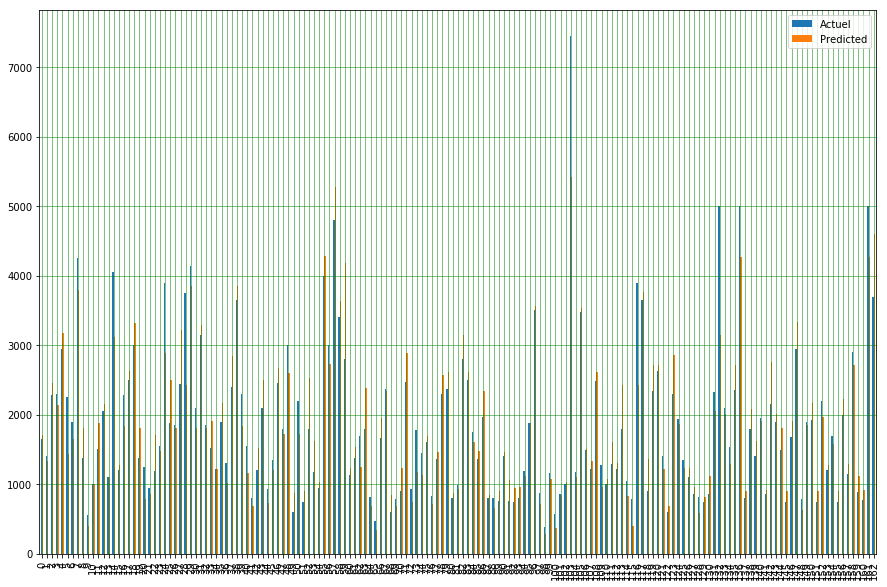

In [128]:
dh2.plot(kind='bar', figsize=(15,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle='-', linewidth='0.5', color='black')
plt.show()

In [129]:
print('Erreur absolue moyenne: ', metrics.mean_absolute_error(ytest, ypred))
print('Erreur quadratique moyenne: ', metrics.mean_squared_error(ytest, ypred))
print('Racine carrée de l erreur quadratique moyenne: ', np.sqrt(metrics.mean_squared_error(ytest, ypred)))

Erreur absolue moyenne:  288.0069740070858
Erreur quadratique moyenne:  180177.0441585226
Racine carrée de l erreur quadratique moyenne:  424.4726659733493


# 6. Conclusion:

On voit que la dernière méthode avec lequel nous avons réalisé nous même le calcul de θ, a une erreur quadratique très légèrement inférieure. Elle caractérise donc une plus faible variance.
Donc cette méthode est plus fiable que celle avec la recherche des coefficients effectuée par LinearRegression().fit().